# Experimental Variogram and Variogram Cloud classes

## Table of Contents:

1. Create Experimental Variogram with the `ExperimentalVariogram` class.
2. Create Experimental Variogram Point Cloud with the `VariogramCloud` class.

## Introduction

The geostatistical analysis starts with a dissimilarity estimation. We must know if a process is spatially dependent and at which distance points tend to be related to each other. Thus, we start with the experimental variogram estimation.
In this tutorial, we will look closely into the API and learn what can be done with two basic experimental semivariogram estimation functionalities. One is the `ExperimentalVariogram` class, and another is the `VariogramCloud` class. The first is a foundation of every other complex function, from semivariogram modeling to Poisson Kriging. The latter is used to analyze relations between points and their dispersion.

We will use **DEM data** stored in a file `samples/point_data/txt/pl_dem_epsg2180.txt`

## Import packages & read data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinterpolate import read_txt, ExperimentalVariogram, VariogramCloud

In [2]:
dem = read_txt('samples/point_data/txt/pl_dem_epsg2180.txt')

# Take a sample
sample_size = int(0.05 * len(dem))
indices = np.random.choice(len(dem), sample_size, replace=False)
dem = dem[indices]

# Look into a first few lines of data
dem[:10, :]

array([[2.51935307e+05, 5.39824073e+05, 2.42116947e+01],
       [2.54853069e+05, 5.48786625e+05, 6.44197464e+01],
       [2.53425208e+05, 5.41201401e+05, 2.57798557e+01],
       [2.42365500e+05, 5.38752888e+05, 1.49989996e+01],
       [2.40255551e+05, 5.49915674e+05, 9.23882217e+01],
       [2.45577801e+05, 5.37130602e+05, 1.90203266e+01],
       [2.42867322e+05, 5.38103486e+05, 1.73995285e+01],
       [2.45623494e+05, 5.46193900e+05, 2.07957134e+01],
       [2.53070429e+05, 5.29963829e+05, 5.51459694e+01],
       [2.39627819e+05, 5.32669732e+05, 2.79635372e+01]])

## 1. Experimental Variogram class

Let's start from the `ExperimentalVariogram` class.

```python

class ExperimentalVariogram:
    
    def __init__(self,
                 input_array,
                 step_size,
                 max_range,
                 weights=None,
                 direction=None,
                 tolerance=1.0,
                 method='t',
                 is_semivariance=True,
                 is_covariance=True):
        ...

```

The class has three required parameters and seven optional.

- `input_array` is a list of coordinates and values in the form `(x, y, value)`. Those are our observations.
- `step_size` parameter, which describes the distance between lags.
- `max_range`, which describes the maximum range of analysis.

What do we know at the beginning? Our coordinate reference system is metric. It is [EPSG:2180](https://epsg.io/2180). We don't know the limits of the region of interest to set the `max_range` parameter. We must define our area size:

In [3]:
# Get max distances for a region

minx = np.min(dem[:, 0])
maxx = np.max(dem[:, 0])

miny = np.min(dem[:, 1])
maxy = np.max(dem[:, 1])

x_max_distance = maxx - minx
y_max_distance = maxy - miny

print('Max lon distance:', x_max_distance)
print('Max lat distance:', y_max_distance)

Max lon distance: 18077.770542611717
Max lat distance: 25081.029885562137


We can assume that the maximum distance `max_range` parameter shouldn't be larger than the maximum distance in a lower dimension (**~18000** m). In reality, the `max_range` parameter is relatively close to the halved value of this distance, and we can check it on a variogram.

But we don't know the `step_size` parameter... Let's assume it is 100 meters, and we will see if we've estimated it correctly.

In [4]:
max_range = 18000
step_size = 100

experimental_variogram = ExperimentalVariogram(
    input_array=dem,
    step_size=step_size,
    max_range=max_range
)

We will visually inspect semivariogram with the `.plot()` method of `ExperimentalVariogram` class: 

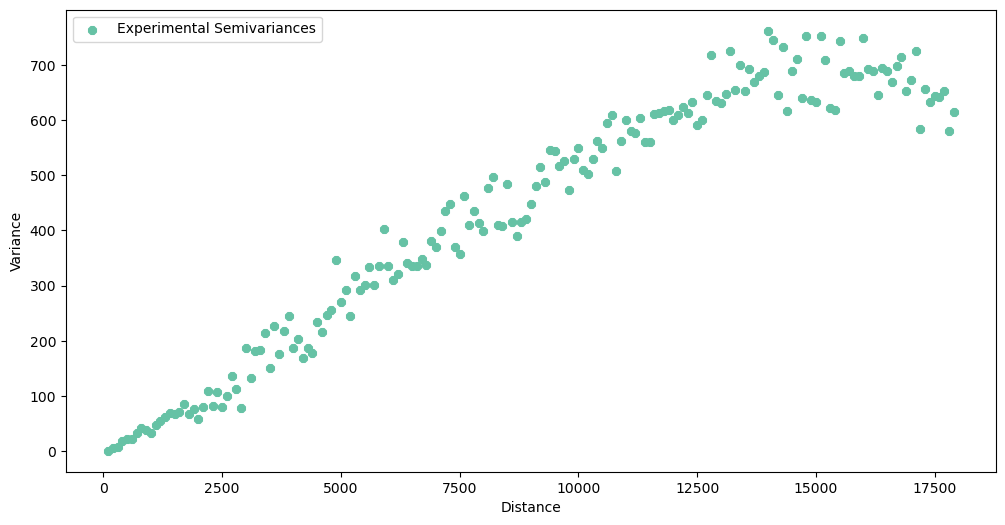

In [5]:
experimental_variogram.plot(plot_covariance=False, plot_variance=False)

Variogram looks nice. We can see a trend, but points are oscillating around it. This piece of information tells us that `step_size` should be larger.

What with the `max_range`? It is a tricky problem because the semivariogram seems right up to the end of its range. The idea is to set the maximum range around half of the study extent because the number of point pairs will fall from this distance.

We can check how many point pairs we have for each distance to make a better decision. The `ExperimentalVariogram` class stores information about points within its attribute `.experimental_semivariance_array`. It is a `numpy` array with three columns: `[lag, semivariance, number of point pairs]`, and we will use the last column to decide where to cut `max_range`.

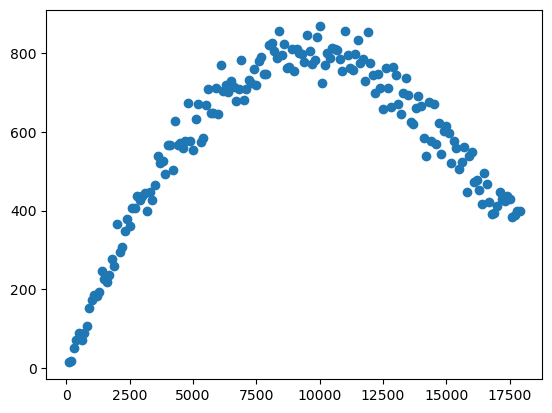

In [6]:
_ds = experimental_variogram.experimental_semivariance_array
plt.figure()
plt.scatter(x=_ds[:, 0], y=_ds[:, -1])
plt.show()

Around the twelve-kilometer number of point pairs rapidly falls, so we can set `max_range` to some value between 7.5 and 12.5 kilometers, we will choose **10000** kilometers as our `max_range`.

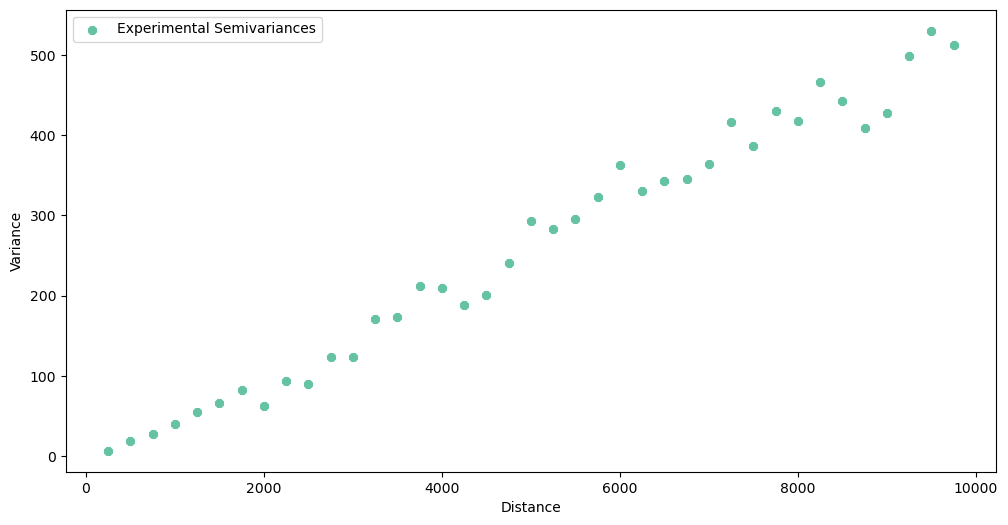

In [7]:
max_range = 10_000
step_size = 250

experimental_variogram = ExperimentalVariogram(
    input_array=dem,
    step_size=step_size,
    max_range=max_range
)

experimental_variogram.plot(plot_covariance=False, plot_variance=False)

This time variogram looks cleaner. However, it still has oscillating readings. Let's set `step_size` to 500 meters:

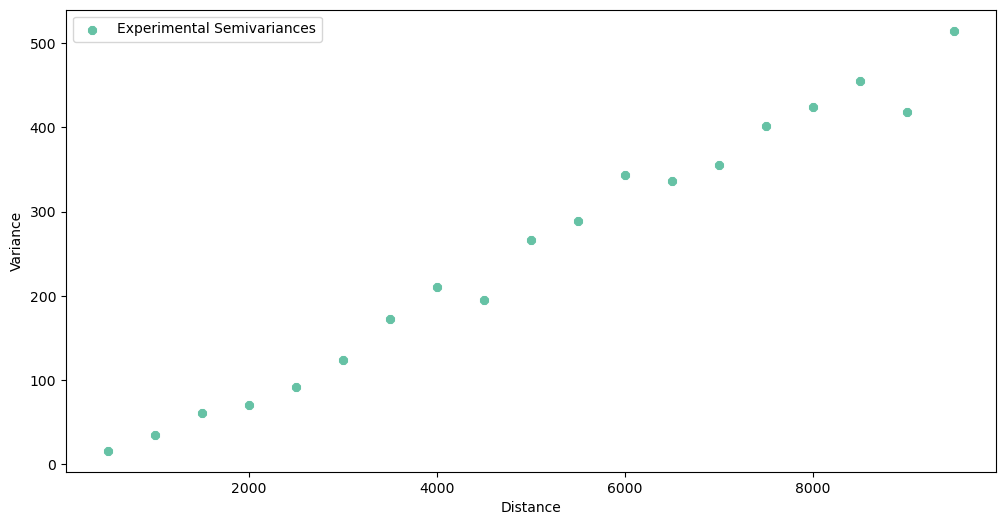

In [8]:
step_size = 500

experimental_variogram = ExperimentalVariogram(
    input_array=dem,
    step_size=step_size,
    max_range=max_range
)

experimental_variogram.plot(plot_covariance=False, plot_variance=False)

We can use those parameters! Next, we will look into the `is_covariance` parameter of the `ExperimentalVariogram` class. It is set to `True` by default. If we want to know the covariance of a dataset, then we should set the `is_covariance` parameter to `True`. Covariance is a measure of spatial similarity, opposite to semivariance. You will see in the plot that they mirror each other. But we can use it in kriging systems instead of semivariance.

`ExperimentalVariogram` plotting function `.plot()` has additional parameters:

- `plot_semivariance` (boolean, set to `True` by default),
- `plot_covariance` (boolean, set to `True` by default),
- `plot_variance` (boolean, set to `True` by default).

We will plot all of those objects in a single figure.


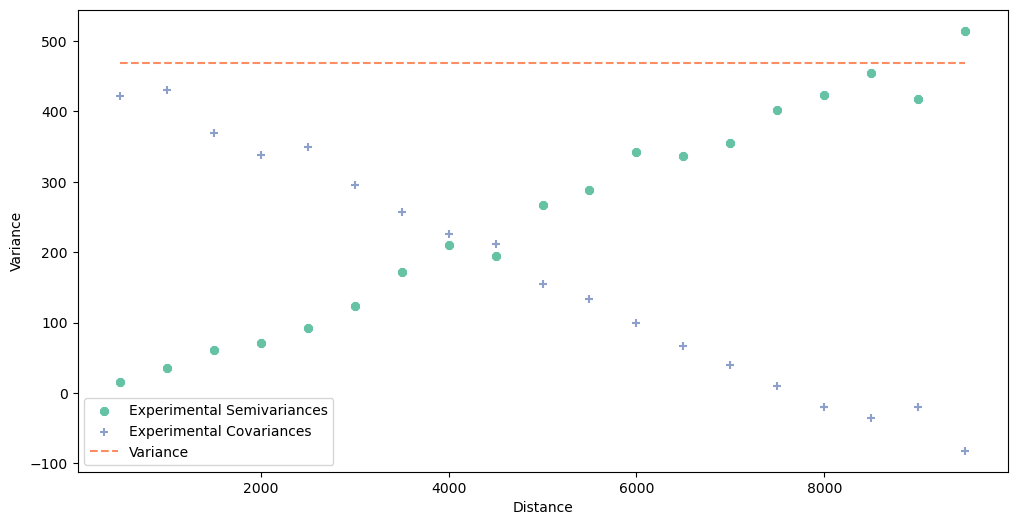

In [9]:
experimental_variogram.plot()

Two important things that we can read from this plot:

1. Experimental covariance is a mirrored version of experimental semivariance, and we can use it to solve the Kriging system instead of semivariance. It is a measure of similarity between point pairs. The highest similarity can be noticed on the first lags and decreases with a rising distance.
2. Variance calculated from data is used later as the **sill** in kriging models, and it can be used to transform semivariances into covariances.

This plot summarizes the basic steps we can do with the `ExperimentalVariogram` class. We left many parameters untouched, but only for a moment. Now we are going to explore all capabilities of the class.

### Optional parameter: `weights`

We won't use this parameter in our tutorial, but we should learn where it comes from. It is a part of **Poisson Kriging** operations. **Poisson Kriging** algorithms use `weights` to weight the semivariance between blocks by in-block population.


### Optional parameters: `direction, tolerance, method`

Those three parameters are used to define a directional variogram. We will check how the variogram behaves in the Weast-East axis (0 degrees).

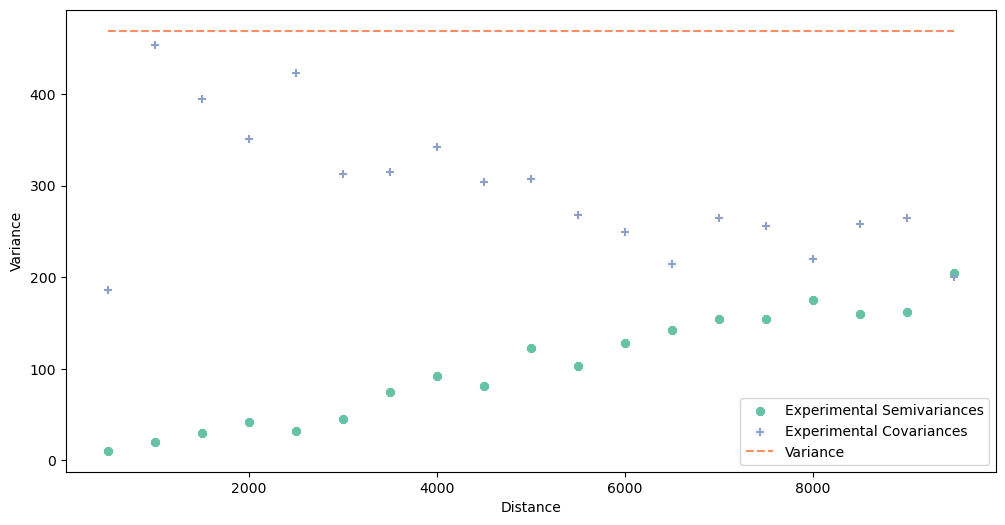

In [10]:
direction = 0
tolerance = 0.1
method = 'e'


experimental_variogram = ExperimentalVariogram(
    input_array=dem,
    step_size=step_size,
    max_range=max_range,
    direction=direction,
    tolerance=tolerance,
    method=method
)

experimental_variogram.plot()

Let's look into the North-South axis too:

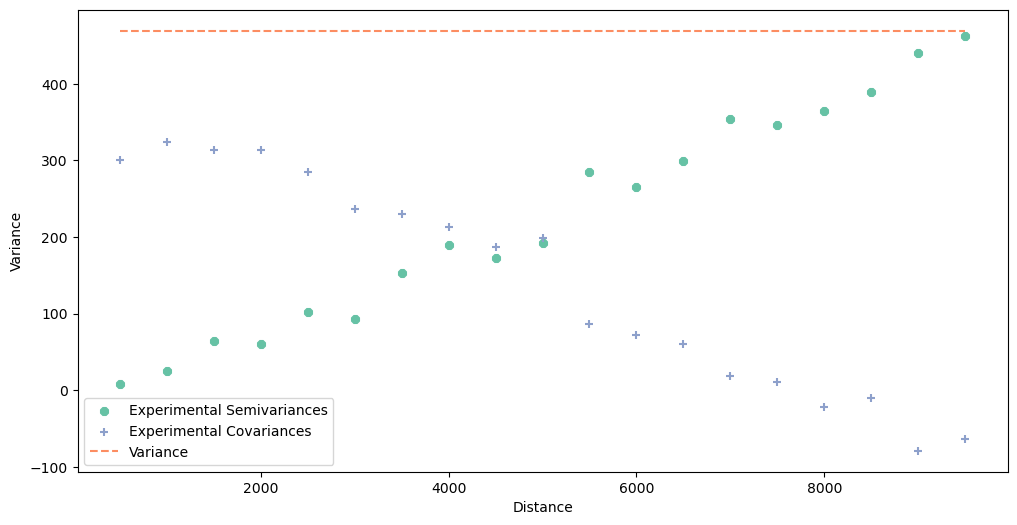

In [11]:
direction = 90

experimental_variogram = ExperimentalVariogram(
    input_array=dem,
    step_size=step_size,
    max_range=max_range,
    direction=direction,
    tolerance=tolerance,
    method=method
)

experimental_variogram.plot()

What can we learn from those plots? Variability along the W-E axis is lower than along the N-S axis. It may indicate continuous spatial structures along the W-E axis (for example, a river plain).

At this point, we are ready for modeling. However, if we want to be precise, we should look into outliers and analyze `VariogramCloud`.

A classic variogram analysis tells us almost everything about spatial dependencies and dissimilarities in data. But there are more spatial investigation tools. We need to learn about the distribution of variances within a single lag, which is valuable information. Semivariogram shows us averaged semivariances. If we want to dig deeper, we should use the `VariogramCloud` class and plot... the variogram cloud.

The `VariogramCloud` class definition API is:

```python

class VariogramCloud:

    def __init__(self,
                 input_array,
                 step_size,
                 max_range,
                 direction=0,
                 tolerance=1,
                 calculate_on_creation=True):
    pass

```

We pass the same parameters to the class as for the `ExperimentalVariogram` class, and the only difference is the `calculate_on_creation` boolean value. Variogram point cloud calculation is a slow operation, and that's why we can start it during or after the class initialization. If we set `calculate_on_creation` to `False`, we must run the `.calculate_experimental_variogram()` method later.

`VariogramCloud` has more methods than `ExperimentalVariogram`:

- `calculate_experimental_variogram()` to obtain the variogram (similar to the output from the `ExperimentalVariogram` class,
- `describe()` to get lag statistics,
- `plot()` to plot variogram cloud,
- `remove_outliers()` to clean the variogram.

We will start with calculation and plotting variogram cloud.

In [12]:
variogram_cloud = VariogramCloud(
    input_array=dem,
    step_size=step_size,
    max_range=max_range
)

We can plot three different kinds of distribution plots: `'scatter', 'box', 'violin'`. We will choose `box` because it clearly shows data distribution in contrast to `scatter` and it's easier to interpret than `violin` plot.

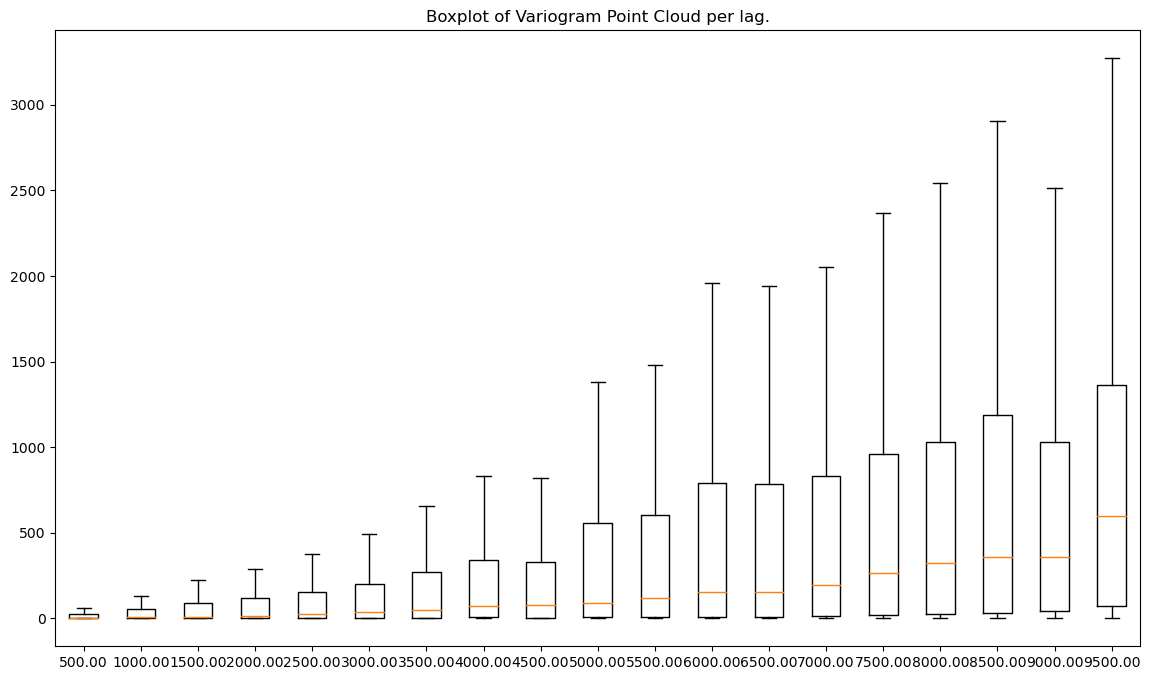

True

In [13]:
variogram_cloud.plot(kind='box')

The general shape is similar to the shape of the experimental variogram. We can see that semivariances between point pairs contain outliers, especially for the lags close to our maximum range. To be sure about outliers' existence, let's look into a more complex violin plot:

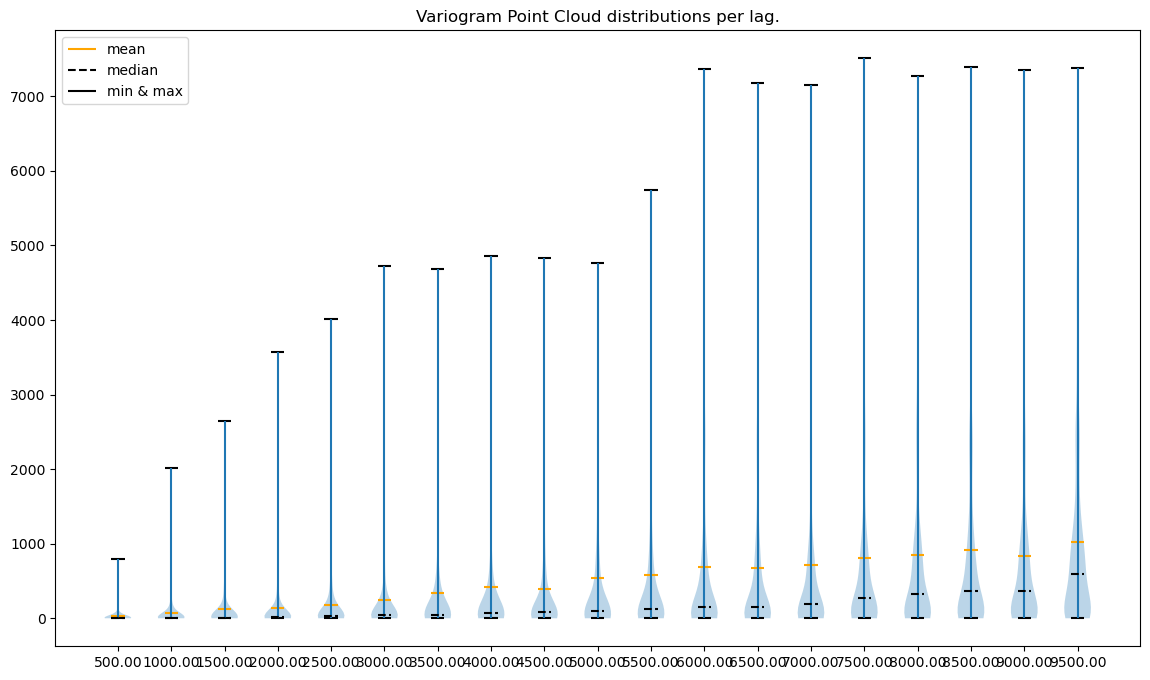

True

In [14]:
variogram_cloud.plot(kind='violin')

Extreme outliers are more visible. Another thing is the difference between the mean and median. Distribution is highly skewed toward large values. If graphical representation is not enough, we may describe statistics with the method `.describe()`:

In [15]:
variogram_cloud.describe()

{500: {'count': 242,
  'avg semivariance': 15.936431854849417,
  'std': 92.25612285094367,
  'min': 0.00014201761223375797,
  'max': 799.5143258391327,
  '25%': 0.7631136541058368,
  'median': 2.825593456524075,
  '75%': 24.71316119832045,
  'skewness': 5.96415496224195,
  'kurtosis': 41.4033384066963,
  'lag': 500},
 1000: {'count': 588,
  'avg semivariance': 35.113218068228086,
  'std': 209.555733766146,
  'min': 2.2159016225486994e-05,
  'max': 2010.4969853698422,
  '25%': 0.646159770025406,
  'median': 6.310839659972771,
  '75%': 54.23459673138859,
  'skewness': 5.966150011743929,
  'kurtosis': 41.34613494693524,
  'lag': 1000},
 1500: {'count': 1036,
  'avg semivariance': 61.1511274806467,
  'std': 347.47419409284515,
  'min': 0.0002365708351135254,
  'max': 2649.6717370428996,
  '25%': 1.0278245718800463,
  'median': 9.446448046373916,
  '75%': 91.12810981046641,
  'skewness': 5.047758479950943,
  'kurtosis': 28.024316106904834,
  'lag': 1500},
 2000: {'count': 1356,
  'avg semiv

We get Python's `dict` as an output, but it is not especially readable; let's convert it to a `DataFrame`:

In [16]:
desc = pd.DataFrame(variogram_cloud.describe())

In [17]:
desc

,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500
count,242.000000,588.000000,1036.000000,1356.000000,1690.000000,2114.000000,2188.000000,2646.000000,2838.000000,2938.000000,3130.000000,3364.000000,3.626000e+03,3568.000000,3644.000000,3884.000000,4072.000000,3916.000000,4032.000000
avg semivariance,15.936432,35.113218,61.151127,70.692237,91.710827,123.296186,171.963849,210.510278,194.531057,266.762373,289.066982,342.850234,3.368246e+02,354.847963,401.590598,423.713594,454.811399,418.132804,514.790185
std,92.256123,209.555734,347.474194,374.615749,470.569894,565.809680,783.271410,869.408617,811.258838,988.977522,1048.964536,1112.713608,1.098528e+03,1105.714249,1207.039726,1225.223309,1263.887635,1164.110530,1277.636792
min,0.000142,0.000022,0.000237,0.000006,0.000137,0.000032,0.000013,0.000014,0.000134,0.000042,0.000003,0.000006,1.499175e-07,0.000164,0.000036,0.000023,0.000111,0.000537,0.000003
max,799.514326,2010.496985,2649.671737,3577.321139,4013.100027,4719.801485,4688.936170,4859.399675,4834.448580,4763.257065,5736.865965,7366.529576,7.181960e+03,7156.297451,7509.587641,7273.248810,7389.054549,7347.555648,7378.280409
25%,0.763114,0.646160,1.027825,1.260922,1.641352,2.217003,2.889471,4.863286,4.139921,4.896885,6.531721,8.077414,9.266486e+00,12.076081,18.469643,25.313764,33.657173,41.867753,71.679997
median,2.825593,6.310840,9.446448,13.132347,24.773655,37.618221,48.682511,72.041982,78.516376,91.435716,118.193950,156.303547,1.508882e+02,191.916348,267.139395,324.404019,359.203741,360.227569,599.627303
75%,24.713161,54.234597,91.128110,116.678301,152.961008,199.378410,268.992333,338.411268,331.694163,556.451662,600.648486,793.210119,7.844150e+02,831.783426,957.971380,1031.646423,1187.214284,1032.429018,1362.519629
skewness,5.964155,5.966150,5.047758,5.228142,4.773363,3.981881,3.540225,3.006132,3.296036,2.568121,2.556979,2.173706,2.207670e+00,2.088475,2.087949,2.037213,1.863372,2.082205,1.840312
kurtosis,41.403338,41.346135,28.024316,32.900511,25.180374,18.734351,13.180778,9.060495,11.398198,6.298002,6.149502,4.544710,4.590427e+00,4.017754,4.238660,4.123719,3.159631,4.410979,3.558473


With this detailed table, we can analyze the variogram in detail and decide:
- if lags are correctly placed,
- if there are enough points per lag,
- if the maximum range is too low or too high,
- is distribution close to normal,

And based on the answers to those questions, we can change semivariogram parameters slightly.

The interesting row is `avg semivariance`. Let's plot it against lags, and let's plot the output from `ExperimentalVariogram` in the same figure:

In [18]:
# Re-calculate experimental variogram

max_range = 10000
step_size = 500

experimental_variogram = ExperimentalVariogram(
    input_array=dem,
    step_size=step_size,
    max_range=max_range
)

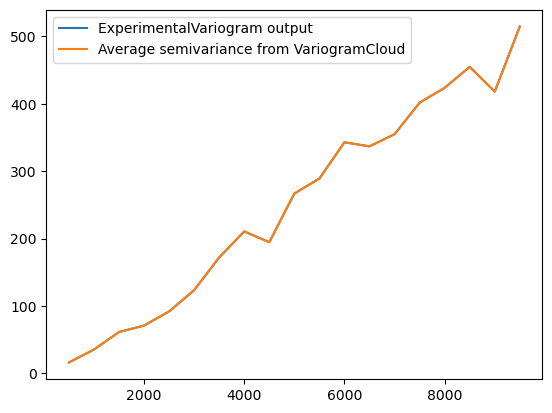

In [19]:
# Plot

plt.figure()
plt.plot(experimental_variogram.experimental_semivariance_array[:, 0], 
         experimental_variogram.experimental_semivariance_array[:, 1])
plt.plot(desc.loc['avg semivariance'])
plt.legend(['ExperimentalVariogram output', 'Average semivariance from VariogramCloud'])
plt.show()

The result is the same, and it shouldn't be a surprise. The experimental variogram averages all semivariances per lag. We stepped back in computations and focused on all point pairs within a lag.

There is one last method within the `VariogramCloud` class: `.remove_outliers()`. It cleans our variogram from anomalous readings. The cleaning default algorithm uses the z-score, but we can also use the interquartile range analysis. Both methods cut outliers from the largest or the lowest intervals. For data that deviates greately from normal distribution, it is better to use an inter-quartile range for cleaning:

In [20]:
new_variogram_cloud = variogram_cloud.remove_outliers(method='iqr', iqr_lower_limit=3, iqr_upper_limit=2)

Now we can check what has happend with the variogram:

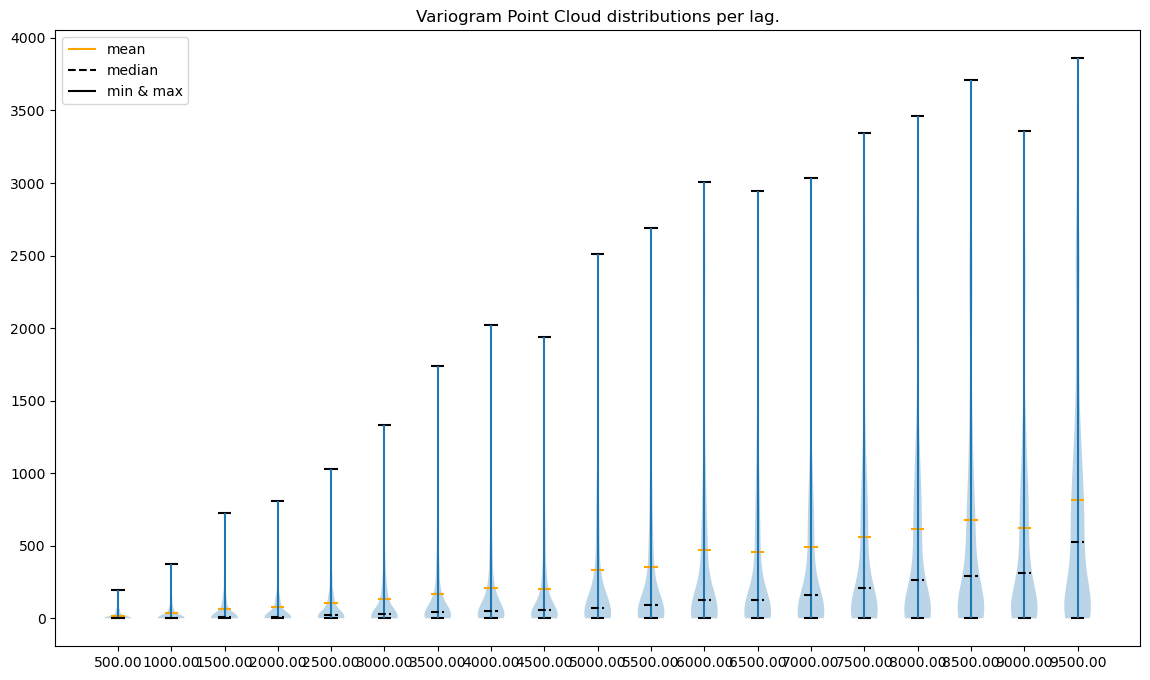

True

In [21]:
new_variogram_cloud.plot(kind='violin')

Maximum semivariances are much lower than before. How does look the averaged semivariogram? Now we will use the `.calculate_experimental_variogram()` method to calculate the variogram directly and compare it to the experimental variogram retrieved from the `ExperimentalVariogram` class.

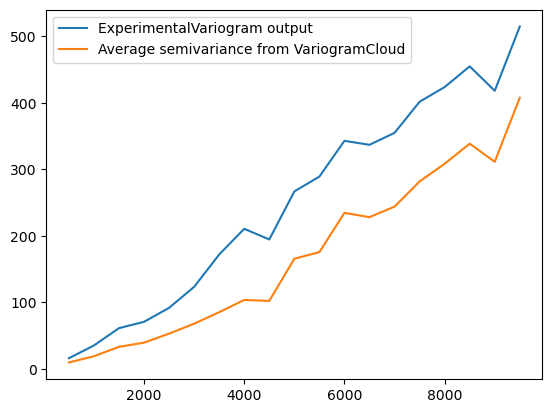

In [22]:
# Plot
exp_var_from_point_cloud = new_variogram_cloud.calculate_experimental_variogram()

plt.figure()
plt.plot(experimental_variogram.experimental_semivariance_array[:, 0], 
         experimental_variogram.experimental_semivariance_array[:, 1])
plt.plot(exp_var_from_point_cloud[:, 0], 
         exp_var_from_point_cloud[:, 1])
plt.legend(['ExperimentalVariogram output', 'Average semivariance from VariogramCloud'])
plt.show()

Now we see that the shape of the variogram persisted, but maximum values per lag are lower. It could be helpful for some models, especially if we eliminate outliers with extreme values.

## Summary

After all those steps, you have better insights into the `ExperimentalVariogram` and `VariogramCloud` classes. You may check your dataset and compare results to those in the tutorial.

The main takeaways from this tutorial are:

- API of `ExperimentalVariogram` and `VariogramCloud` classes,
- differences and similarities between `ExperimentalVariogram` and `VariogramCloud` classes,
- full variogram analysis and preparation before spatial interpolation.

---

## Where to go from here?

* B.1.1 Ordinary and Simple Kriging
* B.3.1 Directional Ordinary Kriging
* C.1.1 Outliers and Kriging Model

## Changelog

| Date       | Change description                                                              | Author                     |
|------------|---------------------------------------------------------------------------------|----------------------------|
| 2023-08-22 | The tutorial was refreshed and set along with the 0.5.0 version of the package  | @SimonMolinsky             |
| 2023-01-23 | The first release of the tutorial | @SimonMolinsky |